# Check GPU


In [48]:
#!nvidia-smi


#Improved RoBERTa for PCL Detection with Enhanced Preprocessing and Hyperparameter Tuning


In [49]:
# Check GPU and install dependencies
!pip install simpletransformers tensorboardx nltk transformers tf-keras tensorflow



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [50]:
import logging, random, pandas as pd, torch
from collections import Counter
from ast import literal_eval
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from urllib import request
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight



In [51]:
# Set up logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print('Cuda available? ', cuda_available)

if cuda_available:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')


Cuda available?  False


In [52]:
# Fetch the Don't Patronize Me! data manager module
module_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name, 'w') as outf:
    outf.write(f.read().decode('utf-8'))


Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [53]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('../data/train/original_data', './data/train/original_data')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [54]:
# Load paragraph IDs for training and official dev set
trids = pd.read_csv('../data/train/sample_splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('../data/train/sample_splits/dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [55]:
data = dpm.train_task1_df

In [56]:
rows = []
for idx in range(len(trids)):
    parid = trids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })
trdf1 = pd.DataFrame(rows)


In [57]:
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [58]:
# Adjust class balance (for binary Task 1: treat label==1 as positive, label==0 as negative)
# Downsample negatives to get a ~1:3 ratio with the positive (PCL) class.
pcldf = trdf1[trdf1.label == 1]
npos = len(pcldf)
balanced_df = pd.concat([pcldf, trdf1[trdf1.label == 0][:npos * 3]])
balanced_df = shuffle(balanced_df, random_state=42)
print("Balanced training set shape:", balanced_df.shape)

Balanced training set shape: (3176, 4)


In [59]:
# Augmentation: Synonym Replacement (EDA)
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def synonym_replacement(text, alpha=0.1):
    words = text.split()
    new_words = []
    for word in words:
        if random.uniform(0, 1) < alpha:
            synonyms = wordnet.synsets(word)
            if synonyms:
                lemmas = synonyms[0].lemma_names()
                if lemmas:
                    new_word = random.choice(lemmas)
                    new_words.append(new_word)
                else:
                    new_words.append(word)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ginevracepparulo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
# Create augmented data by synonym replacement
augmented_rows = []
for idx, row in balanced_df.iterrows():
    new_text = synonym_replacement(row['text'], alpha=0.1)
    augmented_rows.append({
        'par_id': row['par_id'],
        'community': row['community'],
        'text': new_text,
        'label': row['label']
    })
augmented_df = pd.DataFrame(augmented_rows)
balanced_df = pd.concat([balanced_df, augmented_df])
balanced_df = shuffle(balanced_df, random_state=42)
print("After synonym augmentation:", balanced_df.shape)


After synonym augmentation: (6352, 4)


In [61]:
balanced_df

,par_id,community,text,label
41,2105,refugee,"""So , why should Germany of all countries offe...",0
3022,250,migrant,"""Bank of America 's biggest competitors do n't...",0
2113,657,women,"""NBC News has open_fire """" Today ' ' show host...",0
1336,2526,migrant,Some of the deportees who claimed they had bee...,0
56,717,in-need,This year in recognition of their ongoing dedi...,1
...,...,...,...,...
596,6312,hopeless,Remarkable too are the ways in which a childho...,1
2015,1917,homeless,Anthony Torres was just trying to clean up aft...,0
2050,1941,disabled,"Of course_of_study , it can Be disabled by the...",0
2214,2494,immigrant,""""""" There are some immigrants who are working ...",0


In [62]:
# Prepend the community label as an extra feature to the text
balanced_df['text'] = balanced_df['community'] + ": " + balanced_df['text']

In [63]:
balanced_df

,par_id,community,text,label
41,2105,refugee,"refugee: ""So , why should Germany of all count...",0
3022,250,migrant,"migrant: ""Bank of America 's biggest competito...",0
2113,657,women,"women: ""NBC News has open_fire """" Today ' ' sh...",0
1336,2526,migrant,migrant: Some of the deportees who claimed the...,0
56,717,in-need,in-need: This year in recognition of their ong...,1
...,...,...,...,...
596,6312,hopeless,hopeless: Remarkable too are the ways in which...,1
2015,1917,homeless,homeless: Anthony Torres was just trying to cl...,0
2050,1941,disabled,"disabled: Of course_of_study , it can Be disab...",0
2214,2494,immigrant,"immigrant: """""" There are some immigrants who a...",0


In [ ]:
# Augmentation: Backtranslation (using MarianMT)
from transformers import pipeline
translator_en_to_de = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")
translator_de_to_en = pipeline("translation_de_to_en", model="Helsinki-NLP/opus-mt-de-en")

def backtranslate(text):
    de_text = translator_en_to_de(text)[0]['translation_text']
    en_text = translator_de_to_en(de_text)[0]['translation_text']
    return en_text

# Augment a random 20% subset via backtranslation
bt_subset = balanced_df.sample(frac=0.2, random_state=42)
backtranslated_rows = []
for idx, row in bt_subset.iterrows():
    try:
        new_text = backtranslate(row['text'])
        backtranslated_rows.append({
            'par_id': row['par_id'],
            'community': row['community'],
            'text': new_text,
            'label': row['label']
        })
    except Exception as e:
        print("Backtranslation error:", e)
backtranslated_df = pd.DataFrame(backtranslated_rows)


In [ ]:
balanced_df = pd.concat([balanced_df, backtranslated_df])
balanced_df = shuffle(balanced_df, random_state=42)
print("After backtranslation augmentation:", balanced_df.shape)

After backtranslation augmentation: (7622, 4)


In [ ]:
balanced_df

,par_id,community,text,label
2794,2227,hopeless,"hopeless: ""Hopelessness worse the crisis , the...",0
1387,4980,disabled,disabled: Andrew President_Garfield and Claire...,1
1465,1320,homeless,homeless: Scores of survivors are still nursin...,0
871,82,vulnerable,vulnerable: Starbucks is vulnerable to interna...,0
1946,1291,disabled,"disabled: """""" There is a lesson from these cas...",0
...,...,...,...,...
348,935,hopeless,"hopeless: In his view , Professor George Gonge...",1
559,1650,refugee,"refugee: ""He say the refugees who chose J-K as...",0
720,8983,homeless,"homeless: """""" Initially I wanted the charity t...",1
1251,1658,refugee,"Refugee: ""UN Secretary General Antonio Guterre...",0


In [ ]:
import shutil
import nltk
from collections import Counter
import os
# Augmentation: Pos Tag

# Manually specify the download directory
nltk_data_path = os.path.expanduser("~/nltk_data")  # Set to your home directory
nltk.data.path.append(nltk_data_path)

shutil.rmtree(nltk.data.path[0], ignore_errors=True)  # Deletes NLTK data
nltk.download('all')  # Redownload everything

print(nltk.data.path)

def pos_features(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = [tag for _, tag in nltk.pos_tag(tokens)]
    pos_counts = Counter(pos_tags)
    return pos_counts


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/ginevracepparulo/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/ginevracepparulo/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/ginevracepparulo/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/ginevracepparulo/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/ginevracepparulo/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zi

['/Users/ginevracepparulo/nltk_data', '/Users/ginevracepparulo/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/70016_NLP/nlp_env/nltk_data', '/Users/ginevracepparulo/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/70016_NLP/nlp_env/share/nltk_data', '/Users/ginevracepparulo/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/70016_NLP/nlp_env/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/Users/ginevracepparulo/nltk_data']


[nltk_data]    |   Unzipping corpora/words.zip.
[nltk_data]    | Downloading package ycoe to
[nltk_data]    |     /Users/ginevracepparulo/nltk_data...
[nltk_data]    |   Unzipping corpora/ycoe.zip.
[nltk_data]    | 
[nltk_data]  Done downloading collection all


In [ ]:
pos_df = balanced_df.copy()
pos_df["pos_counts"] = pos_df["text"].apply(pos_features)
pos_df

,par_id,community,text,label,pos_counts
2794,2227,hopeless,"hopeless: ""Hopelessness worse the crisis , the...",0,"{'NN': 12, ':': 3, '``': 3, 'NNP': 2, 'VBD': 1..."
1387,4980,disabled,disabled: Andrew President_Garfield and Claire...,1,"{'JJ': 3, ':': 1, 'NNP': 5, 'CC': 2, 'NN': 5, ..."
1465,1320,homeless,homeless: Scores of survivors are still nursin...,0,"{'NN': 2, ':': 1, 'NNS': 4, 'IN': 5, 'VBP': 2,..."
871,82,vulnerable,vulnerable: Starbucks is vulnerable to interna...,0,"{'JJ': 6, ':': 1, 'NNS': 4, 'VBZ': 2, 'TO': 1,..."
1946,1291,disabled,"disabled: """""" There is a lesson from these cas...",0,"{'JJ': 3, ':': 1, '``': 3, '''': 5, 'EX': 1, '..."
...,...,...,...,...,...
348,935,hopeless,"hopeless: In his view , Professor George Gonge...",1,"{'NN': 9, ':': 1, 'IN': 4, 'PRP$': 1, ',': 4, ..."
559,1650,refugee,"refugee: ""He say the refugees who chose J-K as...",0,"{'NN': 4, ':': 1, '``': 3, 'PRP': 1, 'VB': 3, ..."
720,8983,homeless,"homeless: """""" Initially I wanted the charity t...",1,"{'NN': 8, ':': 1, '``': 2, '''': 4, 'NNP': 1, ..."
1251,1658,refugee,"Refugee: ""UN Secretary General Antonio Guterre...",0,"{'NN': 3, ':': 1, '``': 2, 'NNP': 9, 'VBZ': 1,..."


# Prepare Test Set for Task 1 (Official Dev Set)


In [ ]:
# Rebuild dev set (Task 1) with extra feature
rows_test = []
for idx in range(len(teids)):
    parid = teids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows_test.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })
tedf1 = pd.DataFrame(rows_test)

# Prepend community label to text in dev set as well
tedf1['text'] = tedf1['community'] + ": " + tedf1['text']

# Set Up Hyperparameters and Class Weights for the Model


In [ ]:
import numpy as np

# Compute class weights for binary classification
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=balanced_df['label'])
class_weight_dict = dict(zip([int(label) for label in classes], [float(weight) for weight in class_weights]))
print("Class weights:", class_weights)
print("Class weight dict:", class_weight_dict)


Class weights: [0.66497993 2.0153358 ]
Class weight dict: {0: 0.6649799336939453, 1: 2.0153358011634057}


# Vectorize and Model SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Text preprocessing with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X = balanced_df['text']
y = balanced_df['label']

X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train SVM
svm_model = SVC(C=10, gamma= 'scale', kernel= 'rbf', random_state=42, class_weight=class_weight_dict)
svm_model.fit(X_train, y_train)

# Evaluate model
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1138
           1       0.98      0.90      0.94       387

    accuracy                           0.97      1525
   macro avg       0.97      0.94      0.96      1525
weighted avg       0.97      0.97      0.97      1525



In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack

# 🔹 Step 1: 
X_test = tedf1["text"]
X_test_tfidf = vectorizer.transform(X_test) 

# 🔹 Step 2: Make predictions with the trained SVM model
preds_dev = svm_model.predict(X_test_tfidf)  # Predictions
print("Dev set prediction counts:", Counter(preds_dev))

# Helper function to save predictions
def labels2file(p, outf_path):
    with open(outf_path, 'w') as outf:
        for pi in p:
            outf.write(','.join([str(k) for k in pi]) + '\n')

# Save dev set predictions as dev.txt
labels2file([[k] for k in preds_dev], 'dev.txt')

Dev set prediction counts: Counter({np.int64(0): 1948, np.int64(1): 146})


# Evaluation and Visualization on the Dev Set


Dev Set Accuracy: 0.887774594078319
Dev Set Precision: 0.3767123287671233
Dev Set Recall: 0.27638190954773867
Dev Set F1 Score: 0.3188405797101449

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1895
           1       0.38      0.28      0.32       199

    accuracy                           0.89      2094
   macro avg       0.65      0.61      0.63      2094
weighted avg       0.87      0.89      0.88      2094



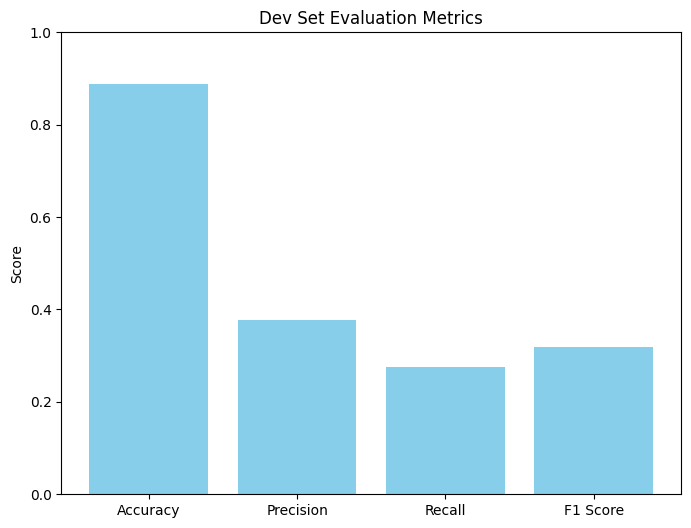

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# --- Compute Evaluation Metrics on the Dev Set ---
true_labels = tedf1['label'].tolist()
accuracy = accuracy_score(true_labels, preds_dev)
precision = precision_score(true_labels, preds_dev)
recall = recall_score(true_labels, preds_dev)
f1 = f1_score(true_labels, preds_dev)

print("Dev Set Accuracy:", accuracy)
print("Dev Set Precision:", precision)
print("Dev Set Recall:", recall)
print("Dev Set F1 Score:", f1)
print("\nClassification Report:\n", classification_report(true_labels, preds_dev))

# --- Plot Evaluation Metrics as a Bar Chart ---
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Dev Set Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()


# Evaluation and Visualization on the Dev Set


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# --- Compute Evaluation Metrics on the Dev Set ---
true_labels = tedf1['label'].tolist()
accuracy = accuracy_score(true_labels, preds_dev)
precision = precision_score(true_labels, preds_dev)
recall = recall_score(true_labels, preds_dev)
f1 = f1_score(true_labels, preds_dev)

print("Dev Set Accuracy:", accuracy)
print("Dev Set Precision:", precision)
print("Dev Set Recall:", recall)
print("Dev Set F1 Score:", f1)
print("\nClassification Report:\n", classification_report(true_labels, preds_dev))

# --- Plot Evaluation Metrics as a Bar Chart ---
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Dev Set Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define hyperparameter grid
param_grid = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],  # Only used for 'poly' kernel
    'class_weight': class_weight_dict
}

# Initialize SVM model
svm = SVC()

X_train = balanced_df['text']
y_train = balanced_df['label']

X_train = vectorizer.fit_transform(X_train)

# Perform Grid Search
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Load Official Test Set and Predict (Using task4_test.tsv)


In [ ]:
# Load the official test set (note: no labels available)
official_test_df = pd.read_csv('../data/test.tsv', sep='\t', header=None, names=['article_id', 'par_id', 'community', 'country', 'text'])

# Print column names
print(official_test_df.columns)

# Prepend community label to text in dev set as well
test_df = official_test_df.copy()
test_df['text'] = official_test_df['community'] + ": " + official_test_df['text']

In [ ]:
# 🔹 Step 1: 
X_test = test_df["text"]
X_test_tfidf = vectorizer.transform(X_test) 

# 🔹 Step 2: Make predictions with the trained SVM model
preds_test = svm_model.predict(X_test_tfidf)  # Predictions
print("Official Test Prediction counts:", Counter(preds_test))

# Save official test set predictions as test.txt
labels2file([[k] for k in preds_test], 'test.txt')

# Prepare Submission

In [ ]:
!cat dev.txt | head -n 10
!cat test.txt | head -n 10
!zip submission_improved.zip dev.txt test.txt